# Example Workflow for Computational Oncology

We will show how the recommended tools can be applied to do analysis in a sample dataset. We chose [Laughney](https://www.nature.com/articles/s41591-019-0750-6),
because it has a good representation of both tumor and immune cells in lung cancer.

This is what they have to say about the characteristics of the study:

We transcriptionally profiled 41,384 single cells obtained from fresh surgical human samples taken from non-tumour-involved lung (n = 4), primary lung adenocarcinomas (n = 8; 7 untreated and 1 post neo-adjuvant chemotherapy), as well as brain (n = 3), bone (n = 1), and adrenal (n = 1) lung adenocarcinoma metastases. These samples were derived from patients spanning various stages of tumour progression without enrichment for a specific cell type, such that the entire tumour and its microenvironment were sampled in an unbiased manner. Data from all patients were merged to create a global cell atlas of the normal lung, primary tumours, and metastases.

We will focus on the primary lung to avoid any sophisticated integration

## Sequence Annotation

In this notebook we work directly with the count matrix and assume that the annotation has been already done.
In the case of Laughney it was done with CellRanger, which simplifies the procedure greatly. 
Though **STARSolo** is often used and is much more flexible.


Care has to be taken in this step, because a faulty annotation would
bias all the following analysis. When in doubt, these tools also come
with possible quality control measures. 

There are two main annotations
used for sequences, the **Ensembl ID**, whose main feature is that it is unique
and the \textbf{gene symbol}, that is more closely related to its discovery
or function. When using different tools, conversion from Ensembl ID
to gene symbol or vice versa is often needed and this depends very much
on the reference database used. Almost all reference datasets come from
the Ensembl webiste, but older platforms use the legacy hg19 reference.


Additionaly, the database can consider not only genes but miRNAs, non-coding 
RNAs and others.

## Import libraries and data

We import the data and lots of libraries we will use later. 

Our main analysis pipeline will be through **Scanpy**, though we will have to change to R, for certain tools.
The basic approach is inspired in [Luecken 2019](https://www.embopress.org/doi/full/10.15252/msb.20188746).

Scanpy works by using a central objectnamed **AnnData** that is specifically designed for count matrices.
It decouples the rows names in the `.obs` attribute and the columns in `.var` and these
are called layers.

Additional
info can be saved in other special layers that don't have to have the dimensions of the
main count matrix, like `.obsm`  for meta info aboutthe rows or `.uns` for info that is 
not tied to anything.

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" alt= “” width="600" height="600">


In [42]:
import gdown
import gzip
import shutil

import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import seaborn as sb

import scarches as sca


# sc.settings.set_figure_params(dpi=200, frameon=False)
# sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(8, 8))

In [98]:
dataset_str = 'laughney_massague_2020_nsclc'
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'

adata = ad.read_h5ad(f'{data_dir}/{dataset_str}.h5ad')
adata = adata[adata.obs.origin == 'tumor_primary']
adata.obs

sample patient         origin condition tissue
120703408884123_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703409633700_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703423507166_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703423561070_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703436306869_0   GSM3516672   LX682  tumor_primary      LUAD   lung
...                        ...     ...            ...       ...    ...
241114562579174_14  GSM3516665   LX675  tumor_primary      LUAD   lung
241114576537973_14  GSM3516665   LX675  tumor_primary      LUAD   lung
241114577300724_14  GSM3516665   LX675  tumor_primary      LUAD   lung
241114589087470_14  GSM3516665   LX675  tumor_primary      LUAD   lung
241114589615901_14  GSM3516665   LX675  tumor_primary      LUAD   lung

[19835 rows x 5 columns]

## Pre-processing and Quality Control

### Filtering

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

Let's see how many mitochondrila genes there and if they are indeed annotated with `MT-`

In [9]:
a = adata.var_names.str.startswith("MT-")
# a = barcodes.index
for i in range(0,len(a)):
    if(a[i] == True):
        print(adata.var_names[i])

MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


In [99]:
# Quality control - calculate QC covariates
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
#Note: this function computes: 
# - `adata.obs['pct_counts_mt']`
# - `adata.obs['total_counts_mt']`
# - `adata.obs['total_counts'`]
# - `adata.obs['n_genes_by_counts']`

adata.obs['log_counts'] = np.log(adata.obs['total_counts'])

/tmp/ipykernel_359/2509325236.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")


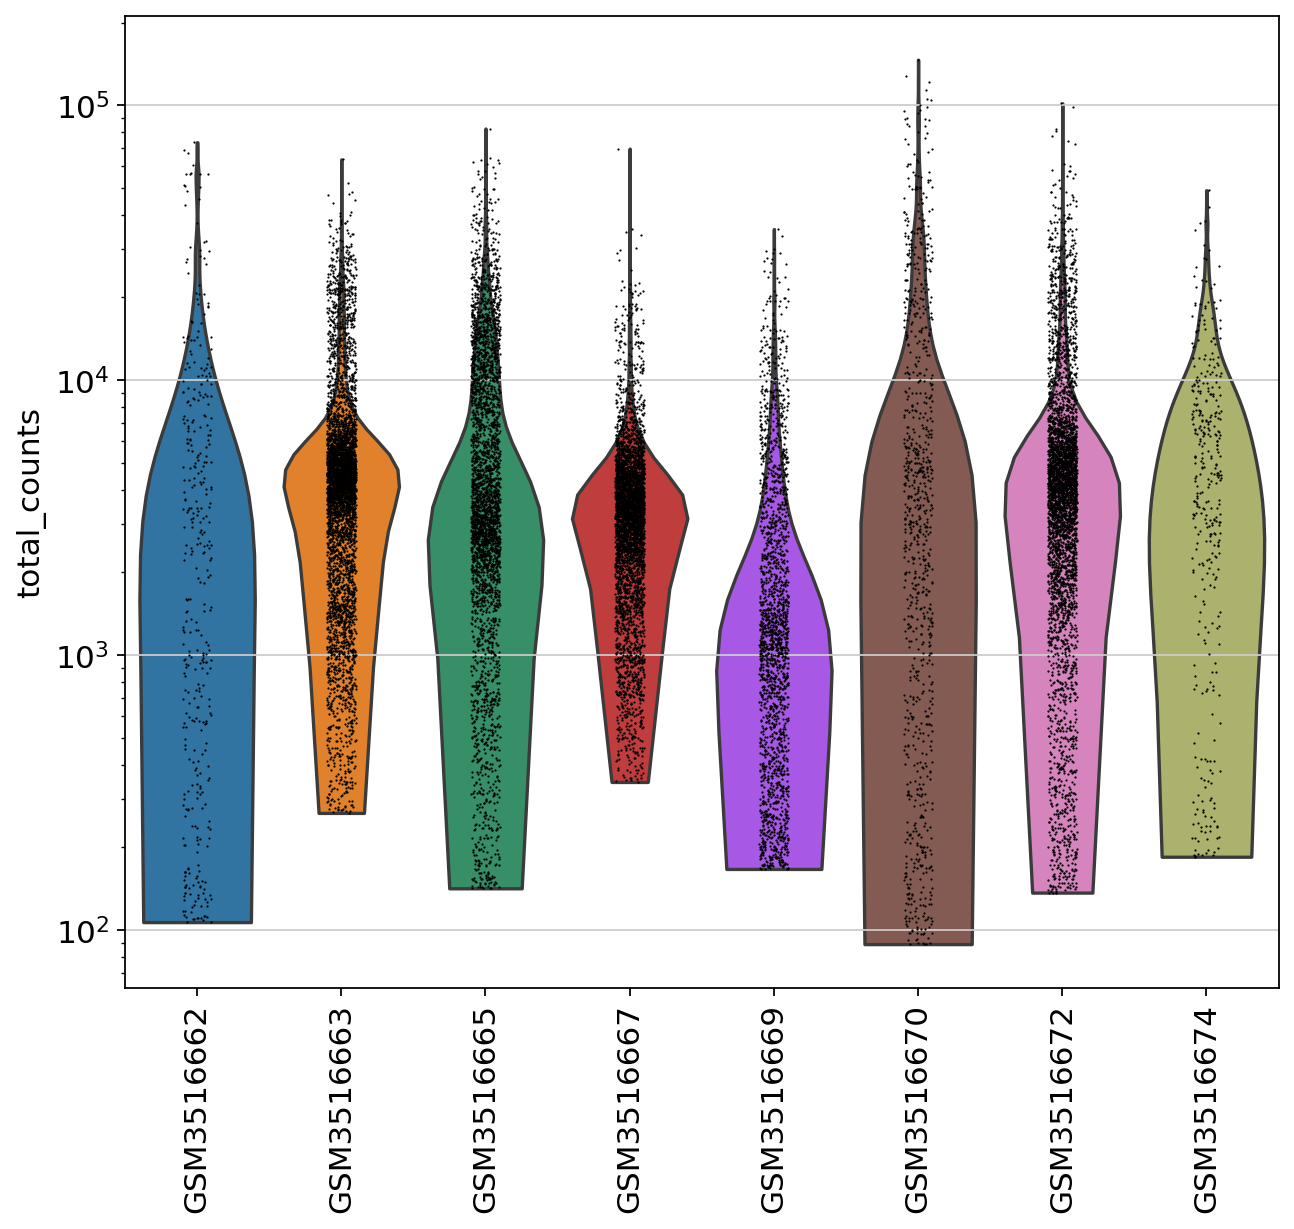

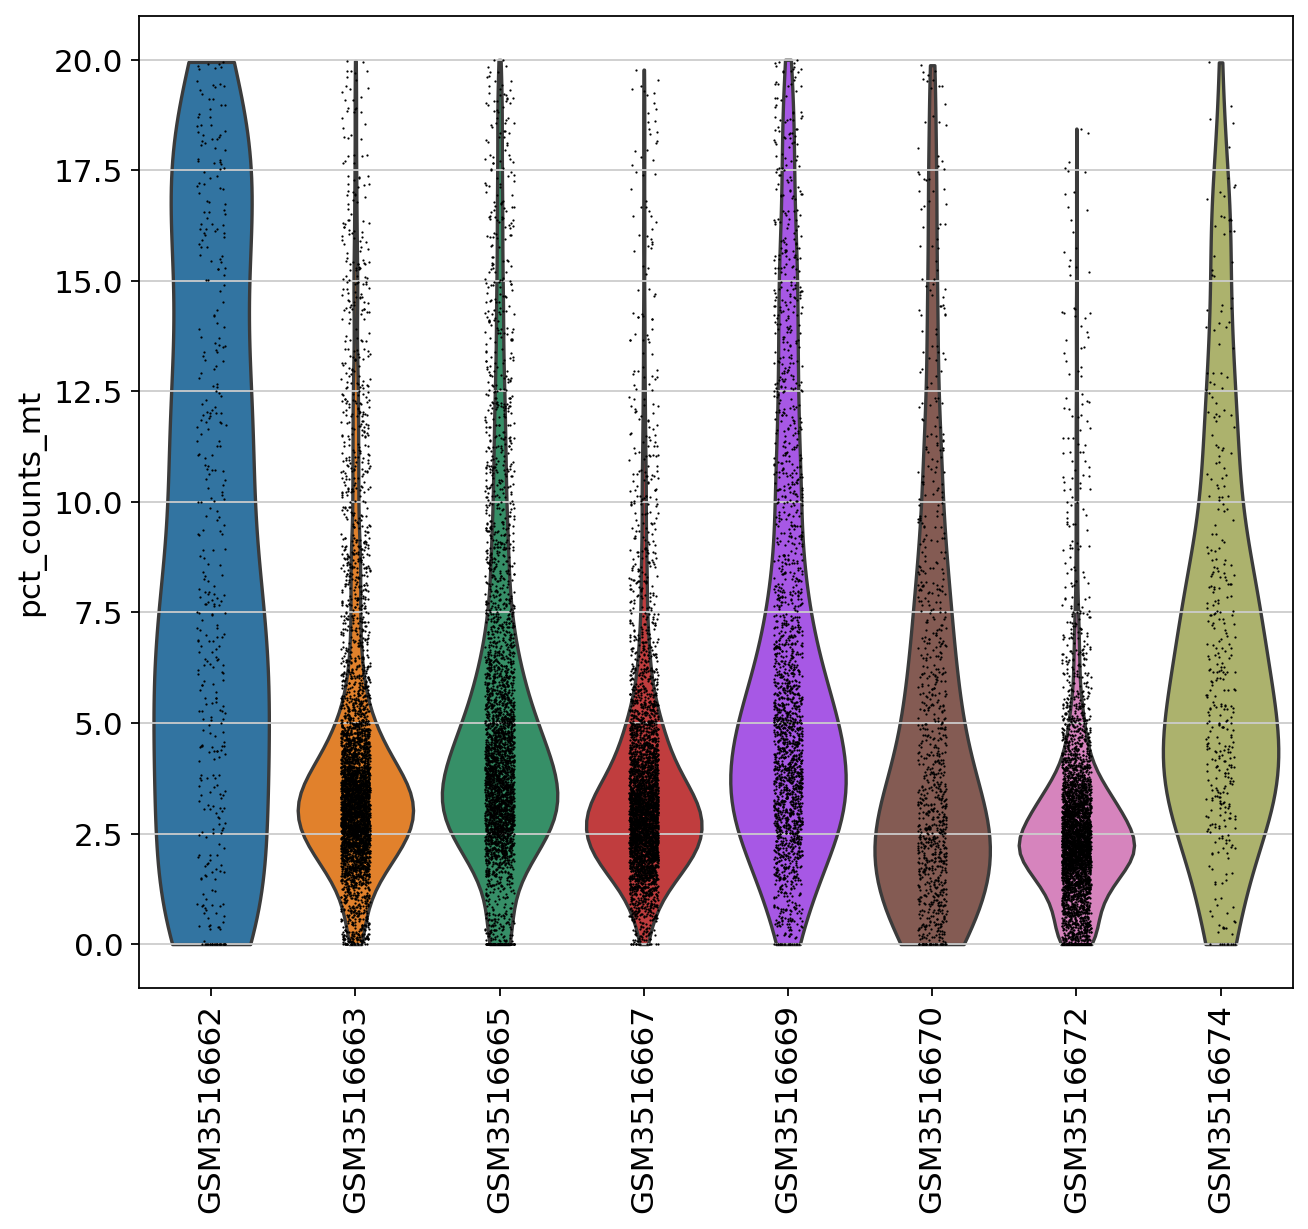

In [101]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'total_counts', groupby='sample', size=1, log=True, cut=0, rotation=90)
t2 = sc.pl.violin(adata, 'pct_counts_mt', groupby='sample', legend=True, rotation=90)

The plots show that the GSM351662 sample has the poorest quality in comparison. The counts per cell are still sufficiently high to process these cells, and the fraction of mitochondrial reads (MT frac) for most cells are still far below 20-25%, which are the typical filtering thresholds.

We could perform QC filtering per sample here to address this issue, yet the mode of the distributions look similar to other samples (e.g., 'GSM3516669'). It may be worth keeping in mind that one sample has a few poorer quality cells though.

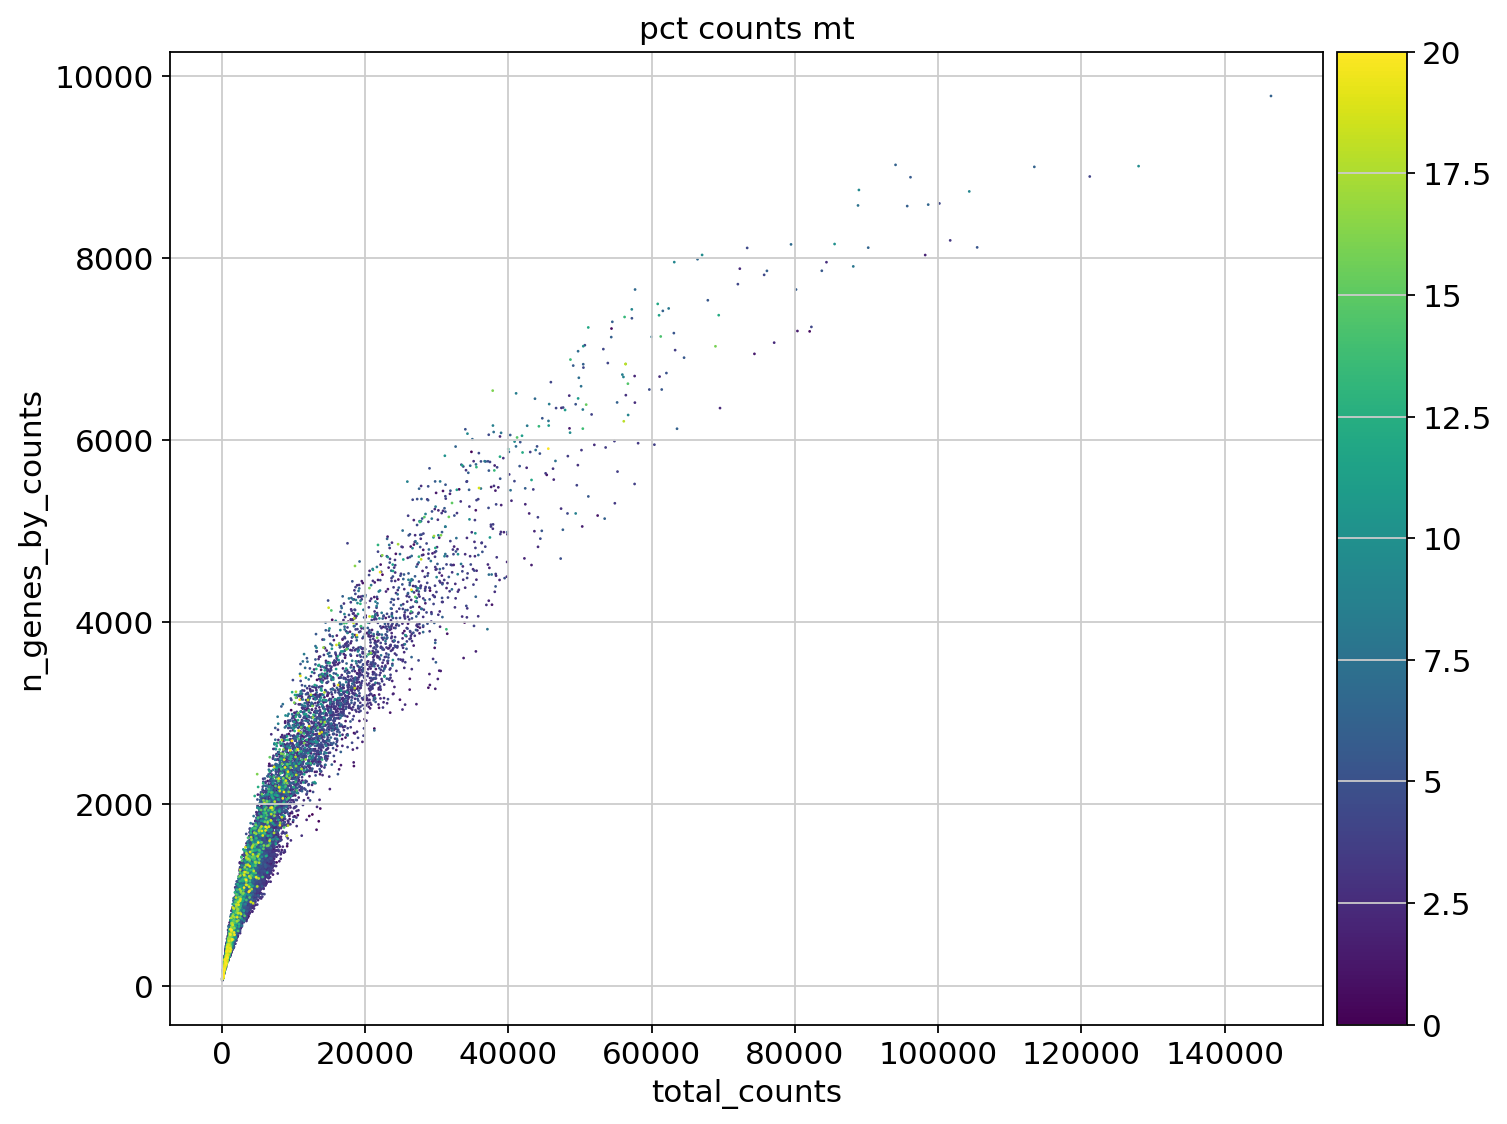

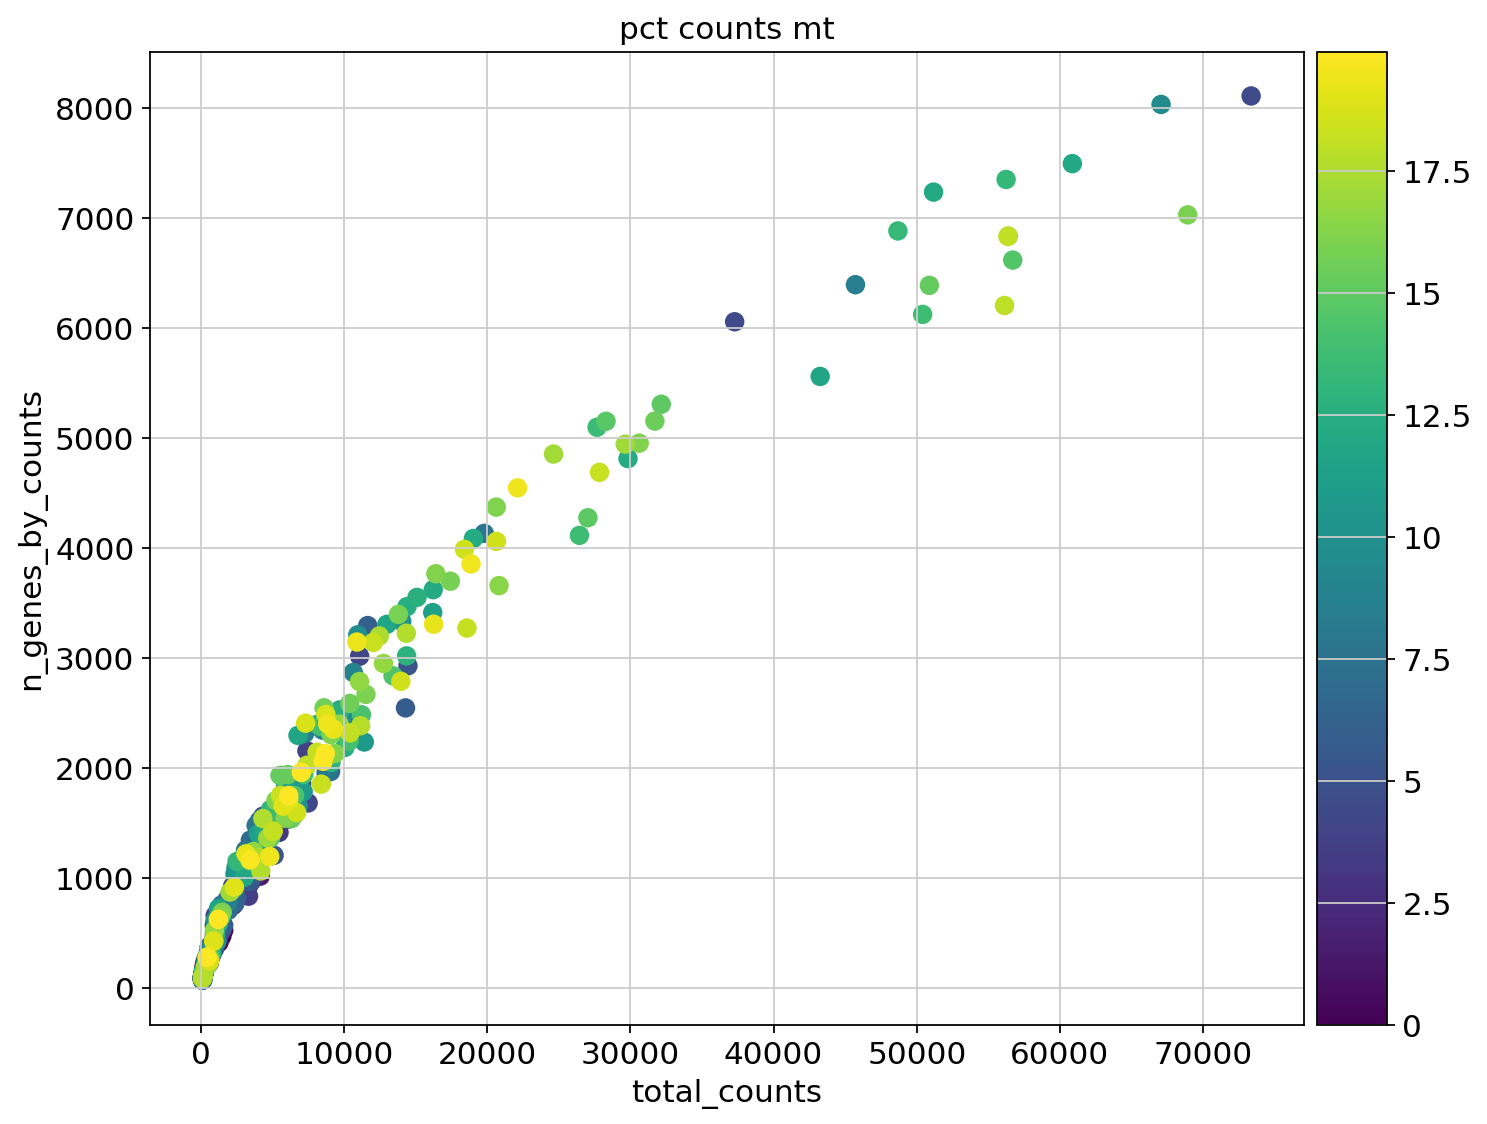

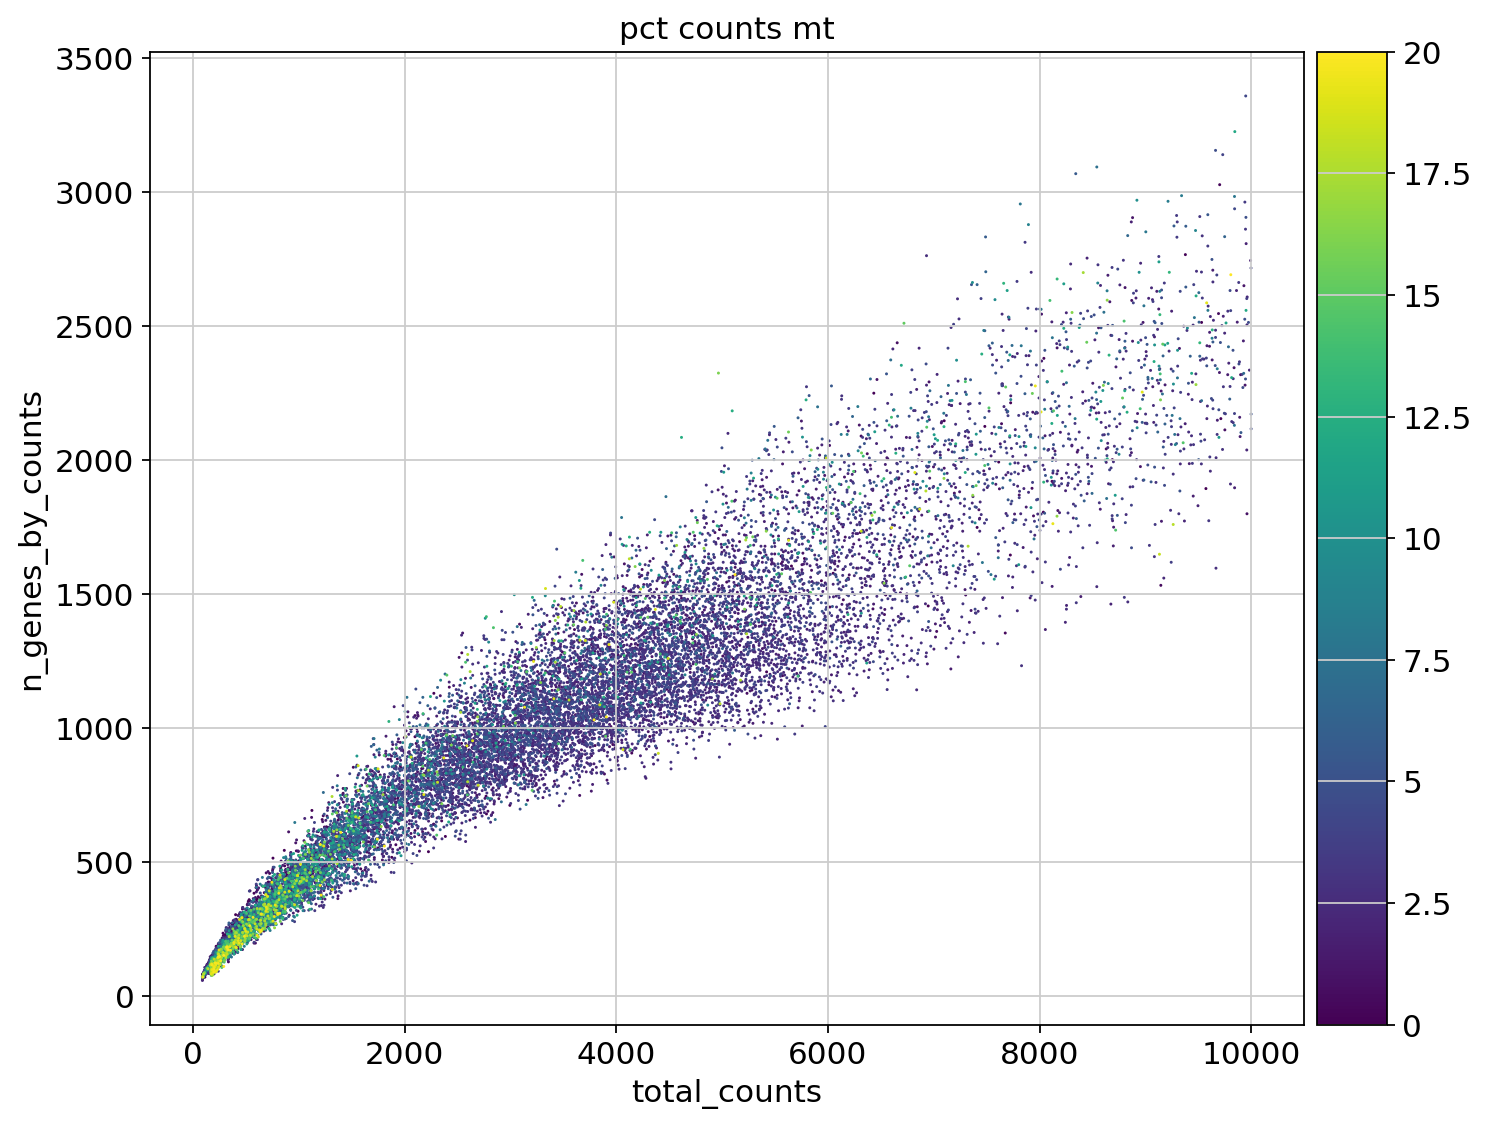

In [102]:
#Data quality summary plots
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')

sc.pl.scatter(adata[adata.obs['sample']=='GSM3516662'], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')

sc.pl.scatter(adata[ (adata.obs['sample']!='GSM3516662') & (adata.obs['total_counts']<10000)], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')


If we substract the sample with the most 
mitochondrial genes *GSM3516662*, the trend is still preserved.

The presence of high mitochondrial percentage in cells with high number of genes is probably a sign of high mitochondrial activity and not dead cells.

In [116]:
adata.obs['sample'].value_counts()

sample
GSM3516663    4566
GSM3516672    4092
GSM3516667    4014
GSM3516665    3435
GSM3516669    2017
GSM3516670     941
GSM3516662     392
GSM3516674     378
Name: count, dtype: int64

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


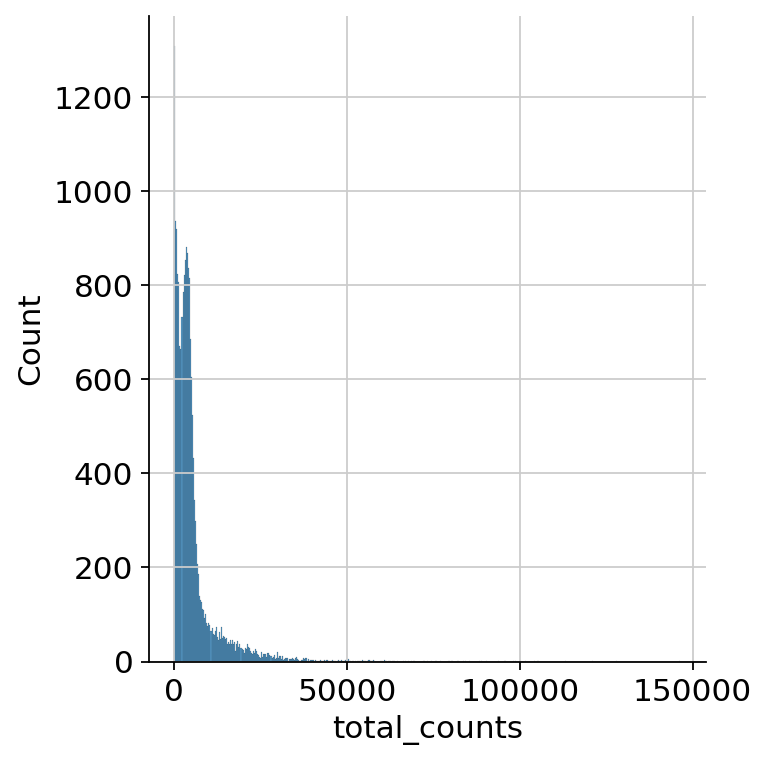

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


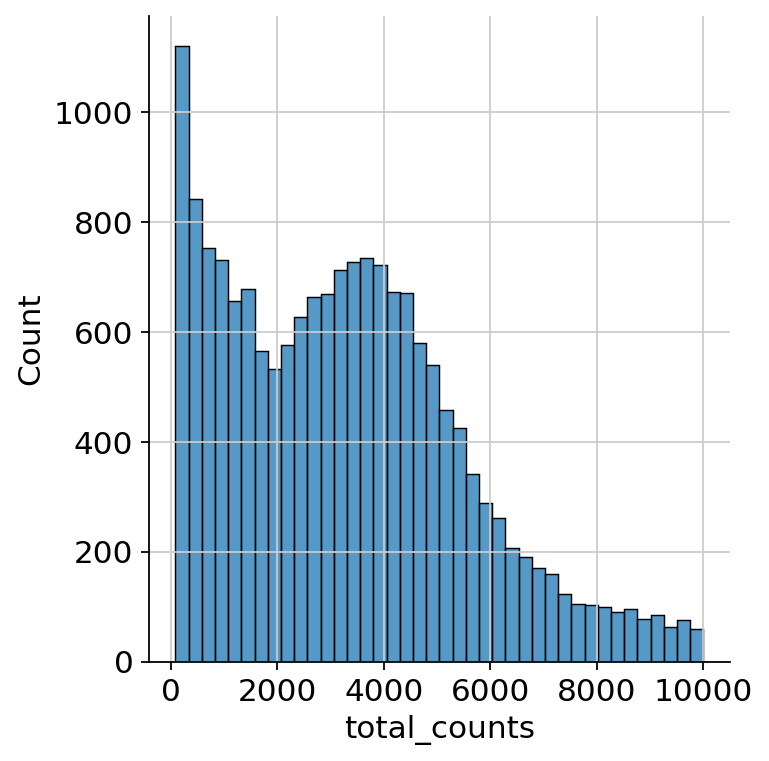

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


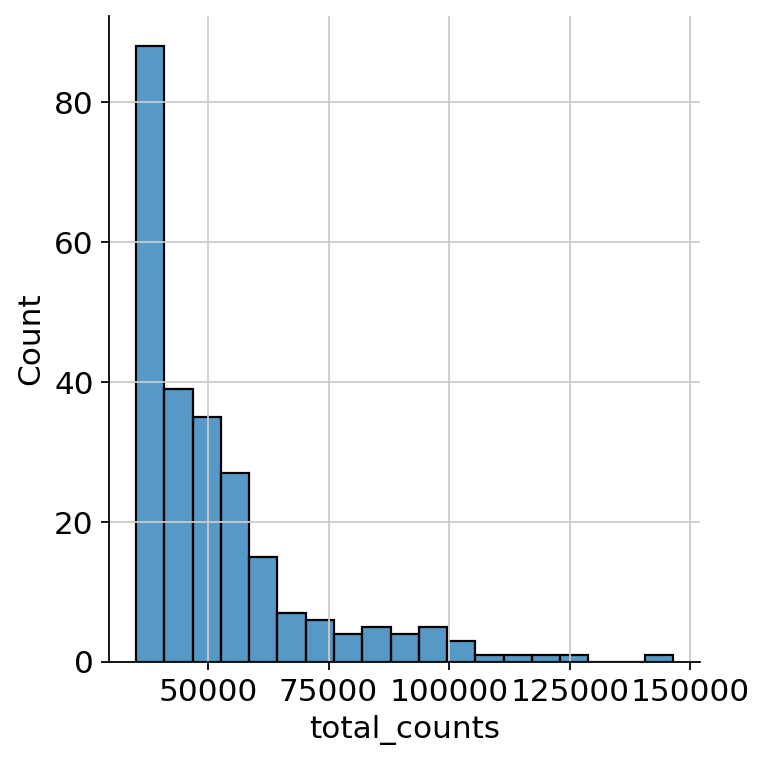

In [117]:
#Thresholding decision: counts
sb.displot(adata.obs['total_counts'], kde=False)
plt.show()

sb.displot(adata.obs['total_counts'][adata.obs['total_counts']<10000], kde=False)
plt.show()

sb.displot(adata.obs['total_counts'][adata.obs['total_counts']>35000], kde=False)
plt.show()

We see a a duble peak of many cells with very little counts, those can be dead cells or ambient RNA, though it is strange
that the counts are so high. Nevertheless, we cutoff at <1800 which is when the population of cells with very fow counts
starts to grow and >40000 when the count abruptly drops.

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


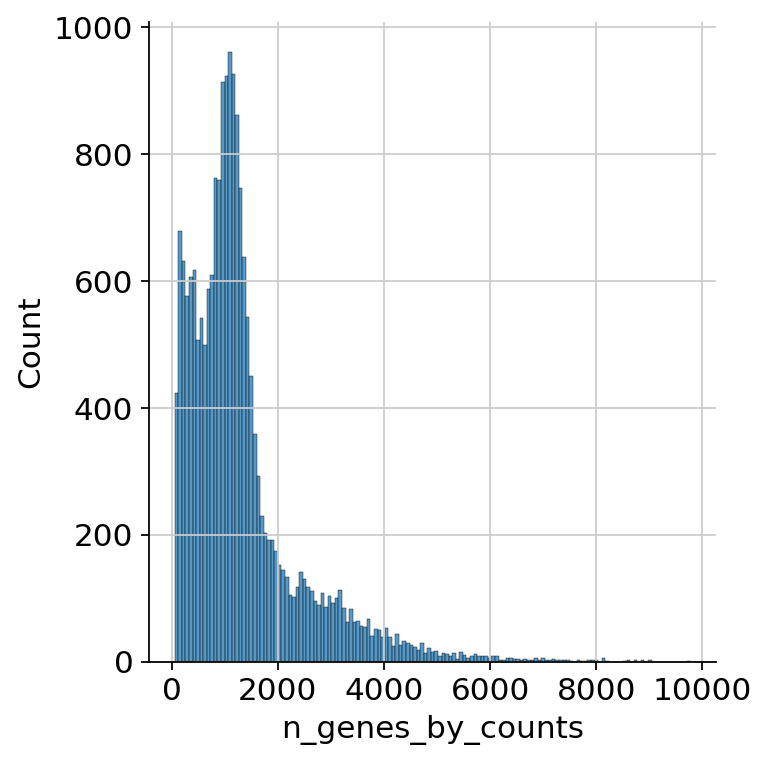

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


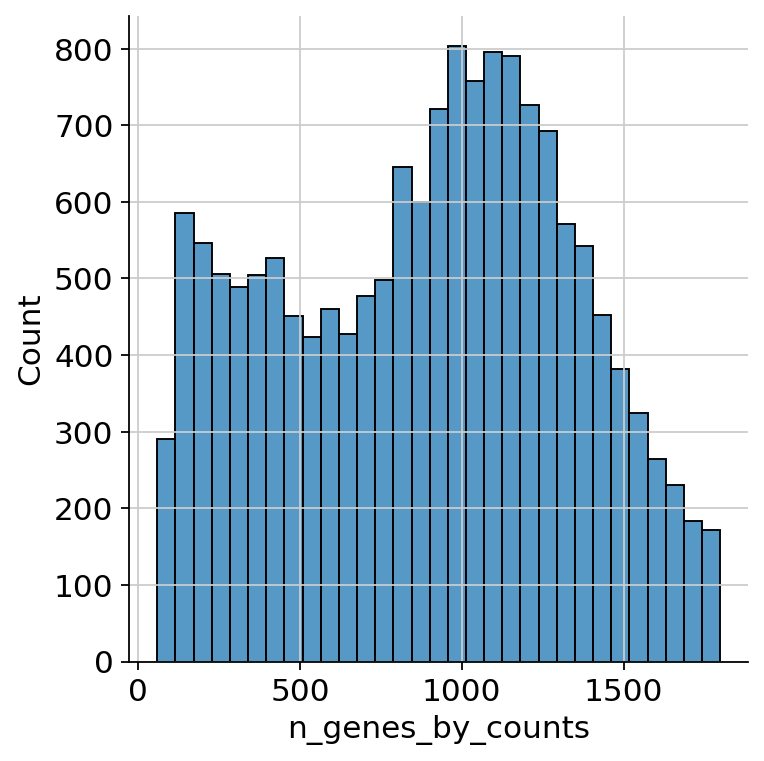

In [105]:
#Thresholding decision: genes
sb.displot(adata.obs['n_genes_by_counts'], kde=False)
plt.show()

sb.displot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1800], kde=False)
plt.show()

By the same critera as before as with total counts we decide the cutoffs to be <500 and >10000.

We also choose a high percentage of max % of mito genes (20%) because of there is a sample that shows mitochondrial activity.

In [122]:
thresholds = {}
thresholds['min_counts']  = 1800
thresholds['max_counts'] = 40000
thresholds['min_genes'] = 500
thresholds['max_genes'] = 10000
thresholds['max_pct_mt'] = 20

In [123]:
# very basic gene filtering - genes with 0 cells cause some downstream processes to fail.
print("Filtering genes")
print(f"    Before: {adata.shape[1]}")
sc.pp.filter_genes(adata, min_counts=1)
print(f"    After: {adata.shape[1]}")

# %%
# Apply thresholds
print("Filter by min_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_counts=thresholds["min_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_counts=thresholds["max_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by min_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_genes=thresholds["min_genes"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_genes=thresholds["max_genes"])
print(f"    After: {adata.shape[0]}")

print("Filter by max_pct_mito")
print(f"    Before: {adata.shape[0]}")
adata = adata[adata.obs["pct_counts_mt"] < thresholds["max_pct_mt"]].copy()
print(f"    After: {adata.shape[0]}")

Filtering genes
    Before: 22057
    After: 22057
Filter by min_counts
    Before: 14396
    After: 14396
Filter by max_counts
    Before: 14396
    After: 14396
Filter by min_genes
    Before: 14396
    After: 14396
Filter by max_genes
    Before: 14396
    After: 14396
Filter by max_pct_mito
    Before: 14396
    After: 14396


### Feature Selection

## Clustering

## Cluster Annotation

### Automated annotation

For a more detailed walkthrough of the process go to https://docs.scarches.org/en/latest/hlca_map_classify.html

IT IS IMPORTANT THAT THE QUERY DATA IS IN RAW COUNTS, WE CHECK THAT HERE:


In [7]:
adata.X[:10, :30].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0

#### Load Query dataset

In [14]:
batch_key = 'dataset'
name = dataset_str.split('_')[0]
query_batch = [f'lung_{name}']
cell_type_key = 'scanvi_label'
data_dir = '/root/datos/maestria/netopaas/lung_scRNA'
backup_dir = '/root/datos/maestria/netopaas/luca_explore'
ref_model_path = f'{data_dir}/HCA_Lung/HLCA_reference_model'

#Important to check how many epochs would be ideal
surgery_epochs = 100
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [15]:
adata_ref = sc.read_h5ad(f'{data_dir}/HCA_Lung/HLCA_emb_and_metadata.h5ad')

In [16]:
adata_query_unprep = adata.copy()

# We need RAW count data for the model we are using so we get it from adata.layers
#adata_query_unprep.X = adata_query_unprep.layers['counts']

For faster computation convert the matrix to sparse.
First check with `adata.X` if it is sparse

In [17]:
adata.X
# adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

<29690x21595 sparse matrix of type '<class 'numpy.float32'>'
	with 51486630 stored elements in Compressed Sparse Row format>

#### Change to Ensembl IDs

Revert to ensemble ids using the assembly reference gch38 (or hg19 in the comments) used in the experiment.
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored on the HLCA Zenodo page, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using BioMart mapping tables. In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary.

Let’s download the HLCA-specific gene mapping:

In [18]:
path_gene_mapping_df = f'{data_dir}/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [18]:
# Download gene information from HLCA github:
url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv"
gdown.download(url, path_gene_mapping_df, quiet=False)

Downloading...
From: https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv
To: /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv
45.1kB [00:00, 54.0MB/s]


'/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [19]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

# Store your gene names in an adata.var.column if they are currently the index:
# if gene names are in .var.index:
adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index
gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [20]:
n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_id_to_gene_name_df.gene_symbol)
    .sum()
)
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)



Number of model input genes detected: 1909 out of 2000 (95%)


Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [21]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_id_to_gene_name_df.gene_symbol
    ),
].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index


In [22]:
adata_query_unprep.var.head(3)

n_counts   mito  n_cells_by_counts  mean_counts  \
ENSG00000121410    6739.0  False               4393     0.190165   
ENSG00000175899   10513.0  False               2640     0.315662   
ENSG00000165029    4021.0  False               2259     0.117918   

                 pct_dropout_by_counts  total_counts gene_names  \
ENSG00000121410              85.203772        5646.0       A1BG   
ENSG00000175899              91.108117        9372.0        A2M   
ENSG00000165029              92.391378        3501.0      ABCA1   

                        gene_ids  
ENSG00000121410  ENSG00000121410  
ENSG00000175899  ENSG00000175899  
ENSG00000165029  ENSG00000165029

In [23]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    adata.obs[col] = adata.obs[col].astype('category')
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
        shape=(len(cat.categories), adata.n_obs),
    )

    return ad.AnnData(
        indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
    )

shape before merging:

Now merge. Note that all var columns will be dropped after merging (as we don’t specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [24]:
adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

In [25]:
adata_query_unprep.shape

(29690, 1909)

add back gene ids:

In [26]:
adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

#### Surgery

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [27]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   
INFO     Found 95.45% reference vars in query data.                                                                


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [28]:
adata_query.obs['scanvi_label'] = 'unlabeled'

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [29]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

We can load the model with this command or train it if we havent got it

In [30]:
adata_query.obs['dataset'] = adata_query.obs['sample']
adata_query.obs['sample'] = adata_query.obs['sample'].astype('string')
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')

In [35]:
for col in adata_query.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_query.obs[col]):
        adata_query.obs[col] = adata_query.obs[col].astype('str')


In [36]:
# Convert all mito falgs into false because we are using the latent genes of the HCA_lung model
# adata_query = sc.read_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')
adata_query.var.mito = False
adata_query.write_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')

Apparently we have to aks for cuda availability explicitly for scArches to recognize that we have GPU

In [38]:
import torch
torch.cuda.is_available()

True

In [39]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


In [40]:
%%time
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:08<00:00,  5.88s/it, v_num=1, train_loss_step=633, train_loss_epoch=669]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:08<00:00,  6.69s/it, v_num=1, train_loss_step=633, train_loss_epoch=669]
CPU times: user 11min 3s, sys: 2.09 s, total: 11min 5s
Wall time: 11min 9s


In [41]:
surgery_model.save(f'{backup_dir}/surgeries/{name}', overwrite=True)

In [24]:
surgery_model = sca.models.SCANVI.load(f'{backup_dir}/surgeries/{name}/', adata_query)

INFO     File surgeries/Chen/model.pt already downloaded                                                           


#### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [42]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

In [43]:
adata_query_latent.write_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')

In [44]:
adata_query_latent = sc.read_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')

#### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [45]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [46]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [20]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [11]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

#### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [47]:
celltypes = f'{data_dir}/HCA_Lung/HLCA_celltypes_ordered.csv'

In [25]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
gdown.download(url, celltypes, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv
5.81kB [00:00, 35.9MB/s]                                                                                                                                                                                                                                                                  


'/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv'

In [48]:
cts_ordered = read_csv(celltypes,index_col=0)

In [49]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [50]:
%%time

labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!
CPU times: user 5min 26s, sys: 1.11 s, total: 5min 27s
Wall time: 41.6 s


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [51]:
uncertainty_threshold = 0.2

In [52]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [53]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [54]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [55]:
def remove_uncert_types(combined_emb):
    import pandas as pd
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [56]:
remove_uncert_types(combined_emb)

AnnData object with n_obs × n_vars = 614574 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [57]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.33%
Level 2: 3.93%
Level 3: 11.14%
Level 4: 23.44%
Level 5: 27.31%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

In [58]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [ ]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [59]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/usr/local/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [60]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [ ]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


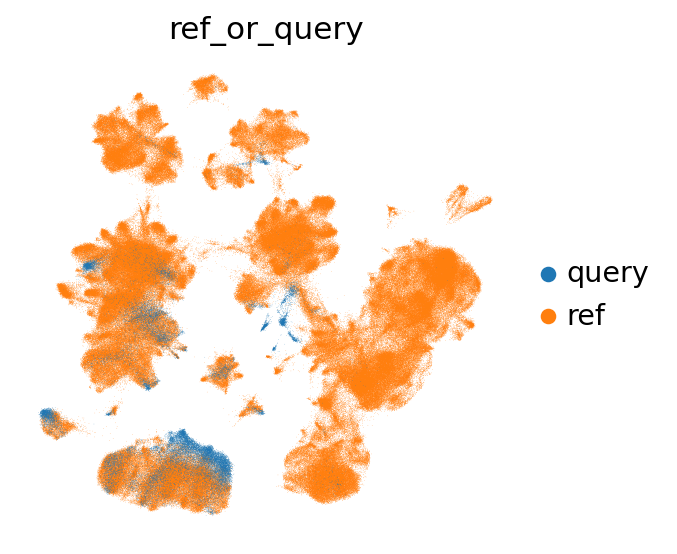

In [61]:
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

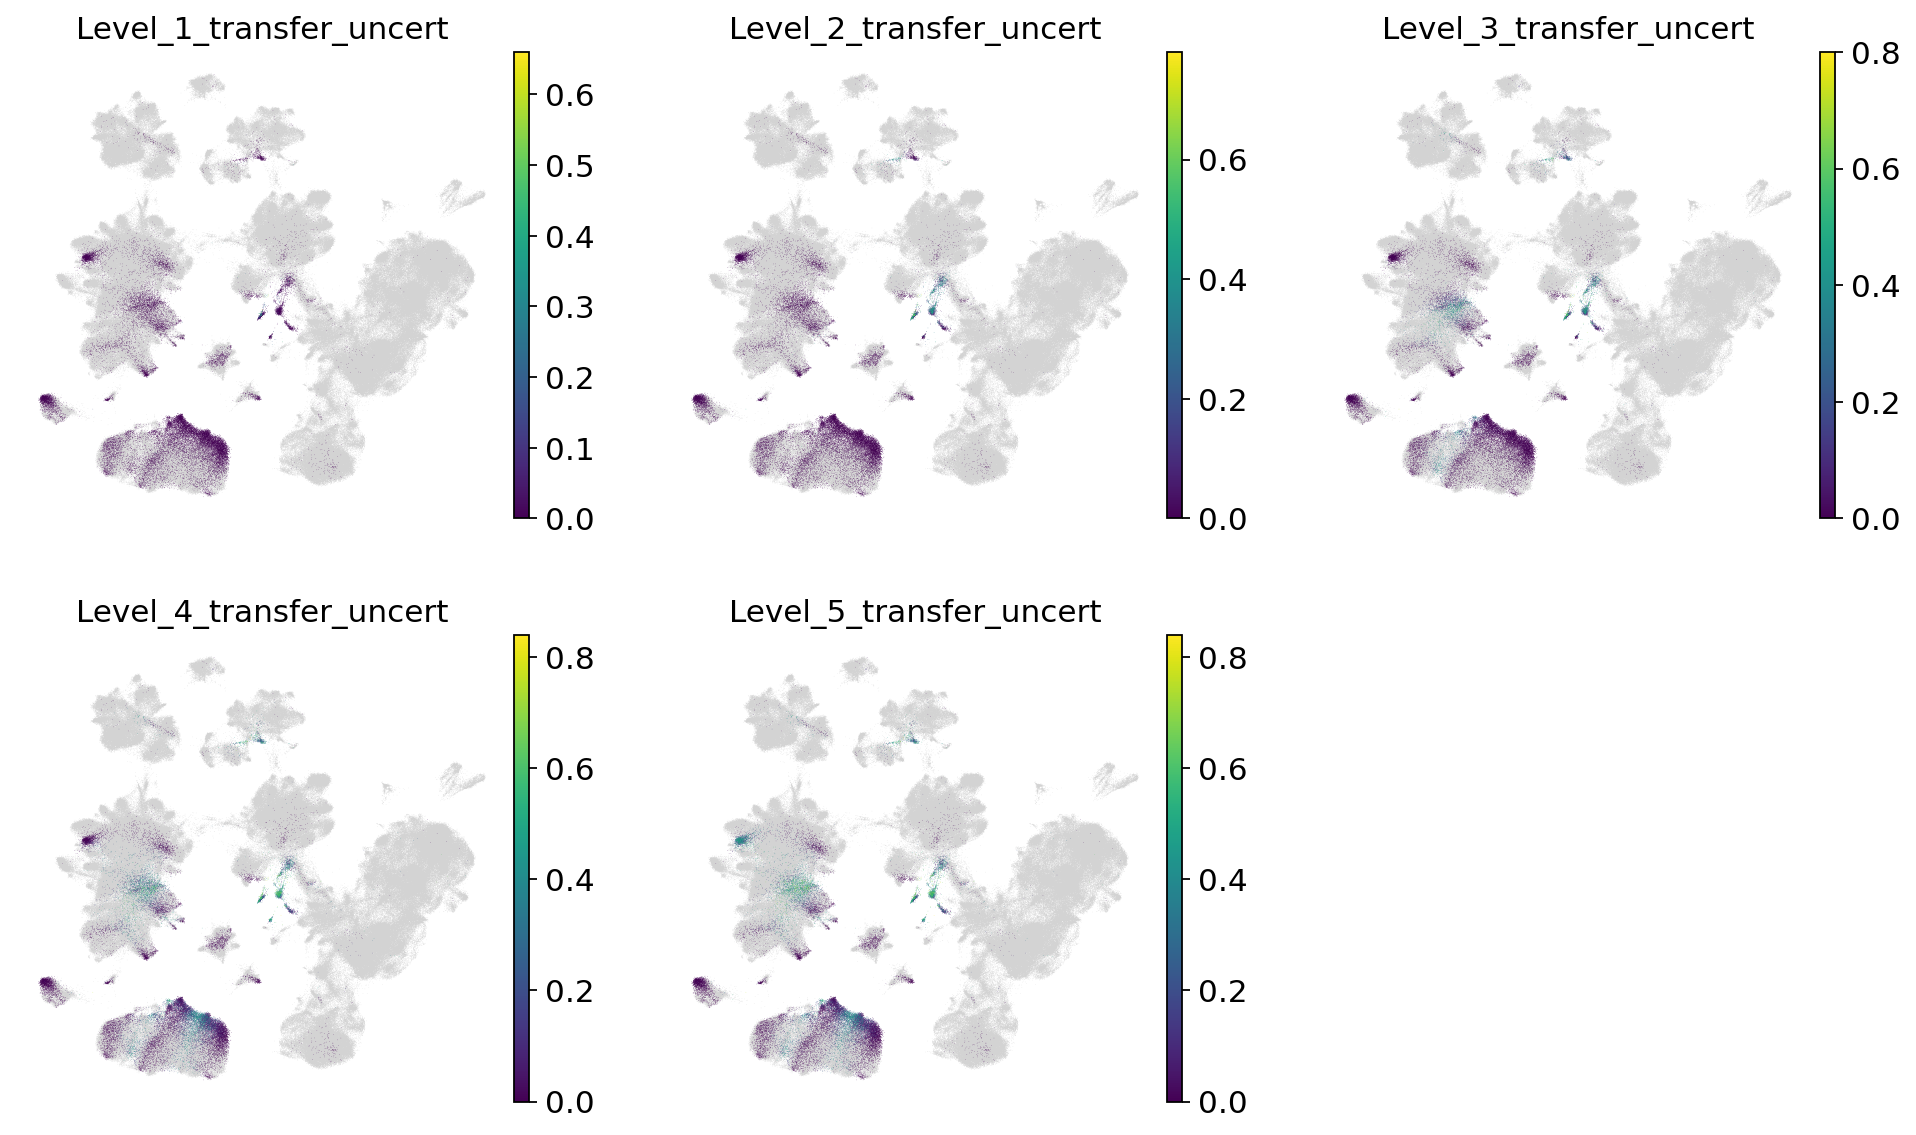

In [62]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


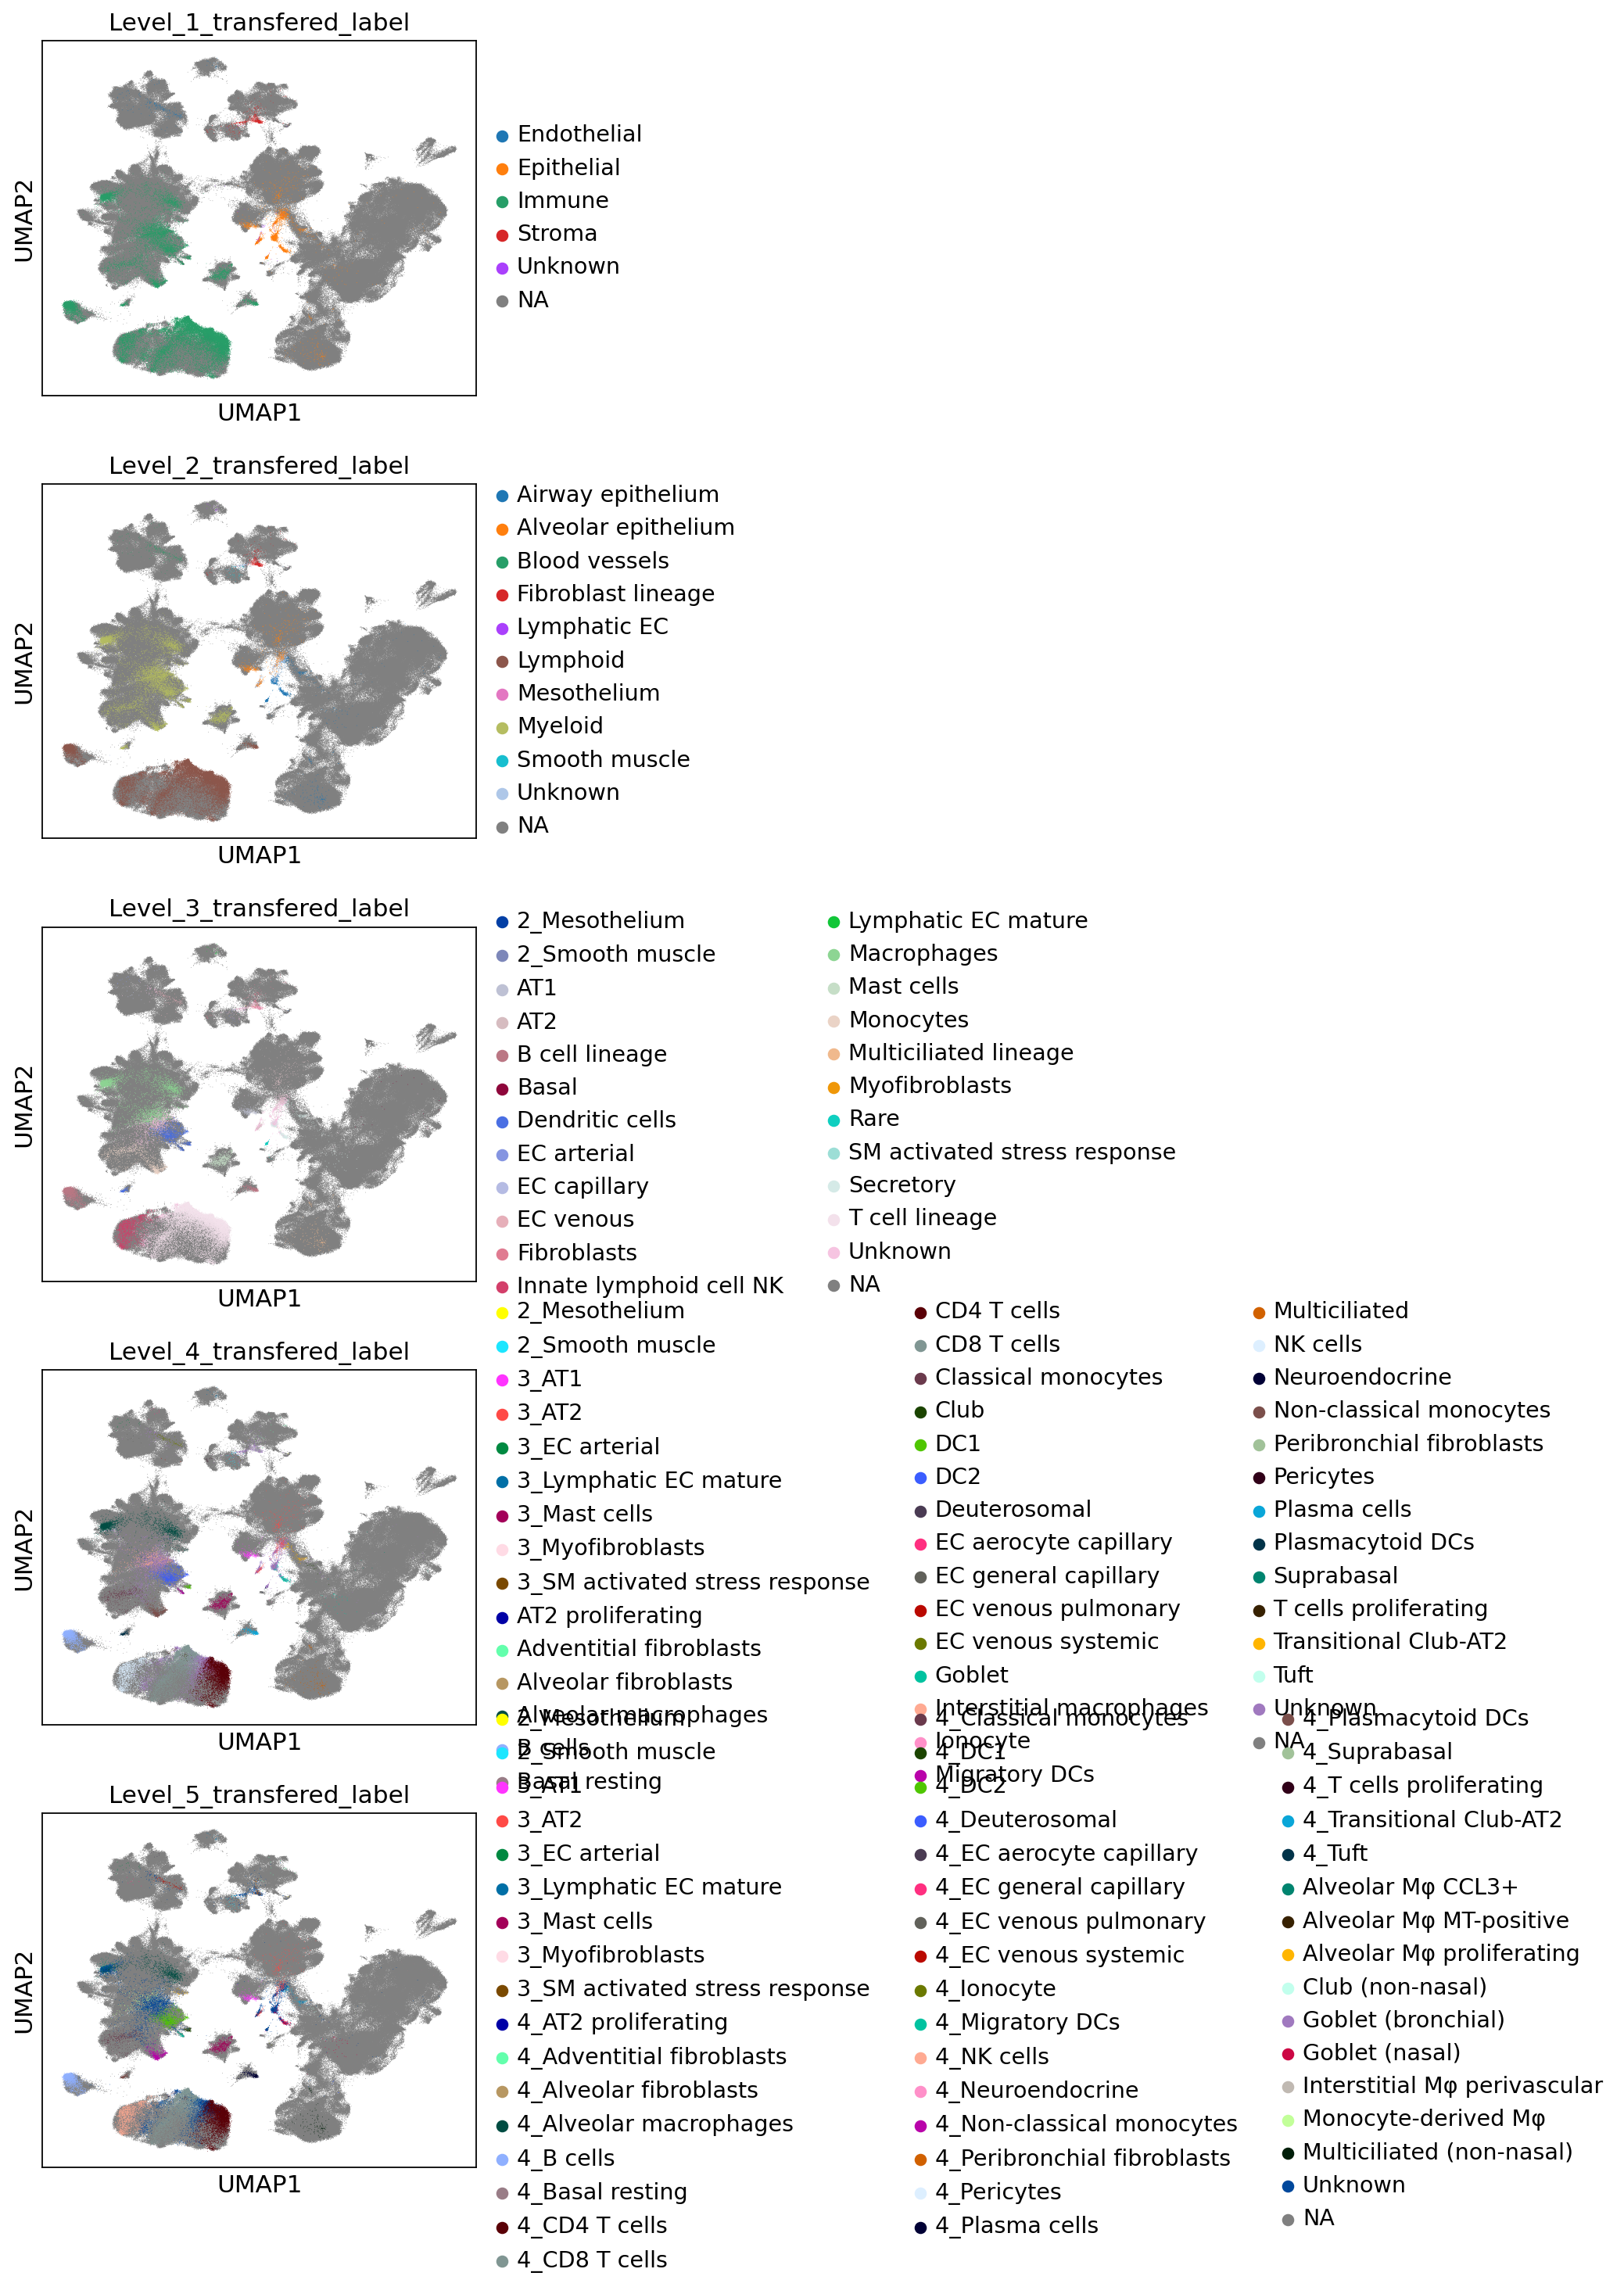

In [63]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

## Trajectory Inference

## Differential Expression and Gene Set Enrichment

## Networks